# Import dependencies and determine working directory

In [1]:
# Import libraries
import os
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Import topic model 
from sklearn.decomposition import NMF

# Get stop words 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Import NLP vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import models 
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [2]:
# get current directory
dir = os.path.dirname(os.path.abspath('__file__'))

# Load pre-processed data

In [3]:
# Load df from a csv - all text to lower case, tokenize into list of strings, remove punctuation and lemmatize
file_path = os.path.join(dir, '02_processed_data','review_text_stars.csv')
joint_df = pd.read_csv(file_path, index_col = False)
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876509 entries, 0 to 2876508
Data columns (total 2 columns):
stars_review        int64
processed_review    object
dtypes: int64(1), object(1)
memory usage: 43.9+ MB


In [4]:
# To be deleted after code is tested 
joint_df = joint_df.head(10000)

# Split data into train and test sets

In [4]:
# Define dependent and independent variables
X = joint_df.processed_review
y = joint_df.stars_review

# Create training and test sets using a fixed seed for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Vectorize data
## Count vectorizer

In [5]:
# Initialize scikit-learn's bag of words tool -  "CountVectorizer"
# Source: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Initial analysis using unigrams and remove all standard stopwords 
count_vectorizer = CountVectorizer(analyzer = 'word',
                             stop_words = 'english',
                             max_df=0.95, 
                             min_df=0.001)

In [6]:
# Transform the training data (independent variables)
count_train = count_vectorizer.fit_transform(X_train)

In [7]:
# Transform the test data (independent variables)
count_test = count_vectorizer.transform(X_test)

In [8]:
# Print the length of features of the count_vectorizer
print( len(count_vectorizer.get_feature_names()) )

3841


## Tfidf vectorizer (weighted vectorizer)

In [65]:
# Initial analysis using unigrams and remove all standard stopwords 
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                             stop_words = 'english',
                             max_df=0.95, 
                             min_df=0.001)

In [66]:
# Transform the training data (independent variables)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [67]:
# Transform the test data (independent variables)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [68]:
# Print the length of features of the tfidf_vectorizer
print( len(tfidf_vectorizer.get_feature_names()) )

3900


# Define models

Initially, the problem will be modelled using classification algorithms. This decision will be revised when looking at methods to improve the model. 

In [9]:
# Define cross_validation_tuning()
def cross_validation_tuning(classifier, param_grid, X_trn, y_trn):
    classifier_cv = GridSearchCV(classifier, param_grid, cv=5)
    classifier_cv.fit(X_trn, y_trn)
    # Print the optimal parameters and best score
    print("Tuned Classifier Parameter: {}".format(classifier_cv.best_params_))
    print("Tuned Classifier Accuracy: {:.3f}".format(classifier_cv.best_score_))
    return classifier_cv

# Define print_test_accuracy_and_cm()
def print_test_accuracy_and_cm(classifier, X_tst, y_tst):
    # Predict the labels
    pred = classifier.predict(X_tst)
    # Compute accuracy
    score = metrics.accuracy_score(y_tst, pred)
    # Calculate and print the confusion matrix
    cm = metrics.confusion_matrix(y_tst, pred, labels=[1,2,3,4,5])
    print('Test Set Score: {:.3f}'.format(score) )
    print('For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.')
    print(cm)

## Naive_bayes model

In [10]:
# Define nb_model()
def nb_model(X_trn, y_trn):
    # Create parameters
    param_grid = {'alpha': np.arange(0, 1, 0.1)}
    # Iterate over the alphas and print the corresponding score
    nb_classifier = MultinomialNB()
    tuned_nb_classifier = cross_validation_tuning(nb_classifier, param_grid, X_trn, y_trn)
    return tuned_nb_classifier

## SVM model

In [11]:
# Define svm_model()
def svm_model(X_trn, y_trn):
    # Create parameters
    param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'C': [1, 10, 100], 'gamma': [0.1, 0.01]}
    svm_classifier = SVC()
    tuned_svm_classifier = cross_validation_tuning(svm_classifier, param_grid, X_trn, y_trn)
    return tuned_svm_classifier

## Logistic regression model

In [12]:
# Define logreg_model()
def logreg_model(X_trn, y_trn):
    # Create parameters
    param_grid = {'C': np.logspace(-5, 8, 15), 'penalty': ['l1', 'l2']}
    logreg_classifier = LogisticRegression()
    tuned_logreg_classifier = cross_validation_tuning(logreg_classifier, param_grid, X_trn, y_trn)
    return tuned_logreg_classifier

## Random forest model

In [13]:
# Define ranforest_model()
def ranforest_model(X_trn, y_trn):
    # Create parameters
    param_grid = {"n_estimators": [2, 10, 100, 300, 1000],
                  "max_depth": [2, 10, 100, 300],
                  "min_samples_split": [2, 10, 100],
                  "min_samples_leaf": [1, 10, 100]}
    ranforest_classifier = RandomForestClassifier()
    tuned_ranforest_classifier = cross_validation_tuning(ranforest_classifier, param_grid, X_trn, y_trn)
    return tuned_ranforest_classifier

# Results

## Naive Bayes for count vectorizer

In [14]:
# Build tuned nb_model for count vectorizer
tuned_nb_classifier = nb_model(count_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_nb_classifier, count_test, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Tuned Classifier Parameter: {'alpha': 0.40000000000000002}
Tuned Classifier Accuracy: 0.586
Test Set Score: 0.586
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[ 66497  19724   5027   1967   2305]
 [ 23496  29399  22557   5720   3117]
 [ 11201  16922  48895  35138  10560]
 [  6065   6549  27411 111408  89006]
 [  5884   2797   5903  55688 249717]]


## SVM for count vectorizer

In [ ]:
# Build tuned svm_model for count vectorizer
tuned_svm_classifier = svm_model(count_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_svm_classifier, count_test, y_test)

## Logistic Regression for count vectorizer

In [ ]:
# Build tuned logreg_model for count vectorizer
tuned_logreg_classifier = logreg_model(count_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_logreg_classifier, count_test, y_test)

Tuned Classifier Parameter: {'C': 31.622776601683793, 'penalty': 'l2'}
Tuned Classifier Accuracy: 0.609
Test Set Score: 0.610
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[ 73334   9045   3415   3723   6003]
 [ 25190  22998  17848  11241   7012]
 [  7322  10560  39826  47491  17517]
 [  1960   1604  12401 116037 108437]
 [  1176    423   1761  42120 274509]]


## Random Forest for count vectorizer

In [ ]:
# Build tuned random forest_model for count vectorizer
tuned_ranforest_classifier = ranforest_model(count_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_ranforest_classifier, count_test, y_test)

## Naive Bayes for tfidf vectorizer

In [69]:
# Build tuned nb_model for tfidf vectorizer
tuned_nb_classifier = nb_model(tfidf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_nb_classifier, tfidf_test, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Tuned Classifier Parameter: {'alpha': 0.10000000000000001}
Tuned Classifier Accuracy: 0.538
Test Set Score: 0.550
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[113  42  23  27  33]
 [ 62  66  61  77  28]
 [ 12  27  90 193  72]
 [  9   4  46 393 392]
 [  4   2  19 218 987]]


## SVM for tfidf vectorizer

In [71]:
# Build tuned svm_model for tfidf vectorizer
tuned_svm_classifier = svm_model(tfidf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_svm_classifier, tfidf_test, y_test)

Tuned Classifier Parameter: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Tuned Classifier Accuracy: 0.568
Test Set Score: 0.582
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[123  68  17  20  10]
 [ 63 104  70  40  17]
 [ 12  55 141 143  43]
 [  5  17  67 433 322]
 [ 11   6  26 241 946]]


## Logistic Regression for tfidf vectorizer

In [70]:
# Build tuned logreg_model for tfidf vectorizer
tuned_logreg_classifier = logreg_model(tfidf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_logreg_classifier, tfidf_test, y_test)

Tuned Classifier Parameter: {'C': 3.7275937203149381, 'penalty': 'l2'}
Tuned Classifier Accuracy: 0.557
Test Set Score: 0.568
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[121  53  21  23  20]
 [ 56  97  64  54  23]
 [  9  39 116 170  60]
 [  7   9  66 401 361]
 [  9   5  13 233 970]]


## Random Forest for tfidf vectorizer

In [74]:
# Build tuned random forest_model for tfidf vectorizer
tuned_ranforest_classifier = ranforest_model(tfidf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_ranforest_classifier, tfidf_test, y_test)

Tuned Classifier Parameter: {'max_depth': 300, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Tuned Classifier Accuracy: 0.511
Test Set Score: 0.520
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[  87   13   12   52   74]
 [  26   13   49  116   90]
 [   3    6   39  213  133]
 [   3    0   16  345  480]
 [   4    0    5  146 1075]]


# Enchancing the feature engineering
Since the best performing models appear to be emerging from the tfidf vectorizer, we will extend the model to include n-gram analysis, and a refined list of stop words.

## Update stop words

In [77]:
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chriskhoo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [78]:
# Add neutral words related to restaurants to list of stop words
stopWords.update(['restaurant', 'place', 'bar', 'service', 'food', 'lunch', 'breakfast', 'dinner', 'price', 'order', 'ordered'])

# Remove stopwords that might reflect sentiment
stopWords = [word for word in stopWords if word not in ['above', 'not', 'below', 't', 'off', 'no', 'again', 'against', 'under', 'hadn', 'up', 'shan', 'more', 'hasn', 'won','couldn', 'wasn', 'mustn', 'out', 'don','down', 'haven', 'price', 'mightn', 'isn', 'wouldn', 'needn', 'shouldn', 'weren', 'aren', 'didn', 'ain', 'doesn']]
print(stopWords)

['to', "should've", 'been', 'as', 'myself', 'yourself', 'does', 'only', 'any', 'them', 'some', 'both', 'our', 'did', 'nor', 'own', 'into', 'do', 'him', 'these', "hadn't", 'because', 'theirs', 'further', 'm', 'service', 'she', "you'll", 'very', 'few', 'me', 'for', 're', 'in', 'while', 'o', 'so', "haven't", 'food', 'an', 'its', 'll', 'before', 'from', 'how', 'that', 'just', 'lunch', "she's", 'his', "doesn't", "mightn't", 'of', 'yourselves', 'having', 'i', 'my', 'a', 'are', 'at', 'it', 'hers', 've', 'ours', 'too', "won't", 'you', 'y', 'have', 'has', 'd', 'yours', "mustn't", 'dinner', 'himself', "don't", 'there', "wouldn't", 'here', 'is', 'whom', "wasn't", 'such', 'doing', 'the', 'when', 'each', 'had', 'but', 'why', "aren't", "weren't", 'or', 'through', 'herself', "shouldn't", 'where', 'now', 'bar', 'on', 'over', 'if', 'with', 'who', "that'll", 'after', "needn't", 'her', 'by', "shan't", 'once', 'their', 'can', 'place', 'will', "didn't", 'ordered', 'between', 'other', 'those', 'this', "you'

## Vectorize text using unigrams, bigrams and trigrams

In [79]:
# Initial analysis using bigrams and unigrams and remove all standard stopwords 
tfidf_vectorizer_ngrams = TfidfVectorizer(analyzer = 'word',
                             stop_words = stopWords,
                             ngram_range = (1,3),
                             max_df=0.95, 
                             min_df=0.001)

In [80]:
# Transform the training data (independent variables)
tfidf_ngrams_train = tfidf_vectorizer_ngrams.fit_transform(X_train)

In [86]:
# Transform the test data (independent variables)
tfidf_ngrams_test = tfidf_vectorizer_ngrams.transform(X_test)

In [82]:
# Print the length of features of the tfidf_vectorizer
print( len(tfidf_vectorizer_ngrams.get_feature_names()) )

9994


## Topic modelling using Non-negative Matrix Factorization (NMF)

In [124]:
# Run NMF
nmf = NMF(n_components=300, random_state=42)

In [125]:
# Transform the training data (independent variables)
nmf_train = nmf.fit_transform(tfidf_ngrams_train)

In [126]:
# Transform the test data (independent variables)
nmf_test = nmf.transform(tfidf_ngrams_test)

In [127]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
display_topics(nmf, tfidf_vectorizer_ngrams.get_feature_names(), 10)

Topic 0:
wa wa not wa delicious wa friendly wa amazing thought wa really wa nice wa wa staff wa
Topic 1:
taco taco wa taco shop shop fish taco best taco gourmet gourmet taco taco salsa taco good
Topic 2:
castle white castle white strip castle burger white castle burger white castle wa castle wa casino cheeseburger
Topic 3:
always always good always fresh always friendly always great staff always always get good always time always usually
Topic 4:
pizza pizza wa great pizza best pizza pizza pizza favorite pizza spinatos pepperoni style pizza pizza ever
Topic 5:
sandwich sandwich wa coleslaw fry sandwich primantis chicken sandwich pastrami turkey beef sandwich fry coleslaw
Topic 6:
beer tap craft craft beer beer tap list duckworths good beer beer selection beer wa
Topic 7:
sushi best sushi sushi bong bong good sushi sushi wa byob sushi ive great sushi best sushi ive
Topic 8:
dog hot dog retro retro dog dog wa coney chicago dog root beer root car
Topic 9:
ice cream ice cream scoop two sco

## Results for ngrams

In [130]:
# Build tuned nb_model for ngrams
tuned_nb_classifier = nb_model(tfidf_ngrams_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_nb_classifier, tfidf_ngrams_test, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Tuned Classifier Parameter: {'alpha': 0.10000000000000001}
Tuned Classifier Accuracy: 0.565
Test Set Score: 0.573
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[127  52  21  18  20]
 [ 70  89  71  54  10]
 [ 11  43 117 180  43]
 [ 11  10  53 417 353]
 [  5   8  29 220 968]]


In [132]:
# Build tuned svm_model for ngrams
tuned_svm_classifier = svm_model(tfidf_ngrams_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_svm_classifier, tfidf_ngrams_test, y_test)

Tuned Classifier Parameter: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Tuned Classifier Accuracy: 0.583
Test Set Score: 0.596
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[126  69  19  11  13]
 [ 57 127  70  27  13]
 [  7  50 151 149  37]
 [  6  14  72 416 336]
 [  8   4  19 230 969]]


In [131]:
# Build tuned logreg_model for ngrams
tuned_logreg_classifier = logreg_model(tfidf_ngrams_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_logreg_classifier, tfidf_ngrams_test, y_test)

Tuned Classifier Parameter: {'C': 3.7275937203149381, 'penalty': 'l2'}
Tuned Classifier Accuracy: 0.581
Test Set Score: 0.589
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[ 130   49   14   18   27]
 [  60  105   69   42   18]
 [   7   47  130  162   48]
 [   5    7   61  402  369]
 [   5    4   14  206 1001]]


In [139]:
# Build tuned random forest_model for tfidf vectorizer
tuned_ranforest_classifier = ranforest_model(tfidf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_ranforest_classifier, tfidf_test, y_test)

Tuned Classifier Parameter: {'max_depth': 300, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Tuned Classifier Accuracy: 0.509
Test Set Score: 0.515
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[  82   13   14   51   78]
 [  24   13   47  121   89]
 [   4    5   35  220  130]
 [   3    0   14  341  486]
 [   3    0    3  149 1075]]


## Results for topic models

In [135]:
# Build tuned nb_model for nmf
tuned_nb_classifier = nb_model(nmf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_nb_classifier, nmf_test, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Tuned Classifier Parameter: {'alpha': 0.0}
Tuned Classifier Accuracy: 0.397
Test Set Score: 0.410
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[   0    0    0    0  238]
 [   0    0    0    0  294]
 [   0    0    0    0  394]
 [   0    0    0    0  844]
 [   0    0    0    0 1230]]


/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [137]:
# Build tuned svm_model for nmf
tuned_svm_classifier = svm_model(nmf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_svm_classifier, nmf_test, y_test)

Tuned Classifier Parameter: {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}
Tuned Classifier Accuracy: 0.532
Test Set Score: 0.551
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[120  46  20  23  29]
 [ 60  89  54  58  33]
 [ 23  47 108 160  56]
 [ 14  23  54 359 394]
 [ 18   8  21 206 977]]


In [136]:
# Build tuned logreg_model for nmf
tuned_logreg_classifier = logreg_model(nmf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_logreg_classifier, nmf_test, y_test)

Tuned Classifier Parameter: {'C': 11787686.347935867, 'penalty': 'l1'}
Tuned Classifier Accuracy: 0.545
Test Set Score: 0.567
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[123  48  16  21  30]
 [ 67  96  64  41  26]
 [ 16  64 110 151  53]
 [ 14  17  69 377 367]
 [ 20  12  22 182 994]]


In [138]:
# Build tuned random forest_model for nmf
tuned_ranforest_classifier = ranforest_model(nmf_train, y_train)

# Print test score and CM for tuned model
print_test_accuracy_and_cm(tuned_ranforest_classifier, nmf_test, y_test)

Tuned Classifier Parameter: {'max_depth': 300, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Tuned Classifier Accuracy: 0.530
Test Set Score: 0.539
For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
[[ 111   16   14   45   52]
 [  41   43   55   97   58]
 [  13   11   58  223   89]
 [   5    2   19  366  452]
 [   8    0    6  176 1040]]


# Code to delete
# .
# . 
# .
# .
# .
# .
# . 
# .
# .
# .
# .
# . 
# .
# .
# .
# .
# . 
# .
# .
# .

## Vectorize text

In [22]:
# Vectorize text and convert the result to an Numpy array
vectorized_text = vectorizer.transform(" ".join(line) for line in joint_df['processed_review'])
vectorized_text_array = vectorized_text.toarray()

## Explore word vector properties and most common words

In [23]:
# Get list of words in the vocabulary
vocab = vectorizer.get_feature_names()

# Sum up the counts of each vocabulary word
dist = np.sum(vectorized_text_array, axis=0)

# Explore vector metrics
print ('sparse matrix shape:', vectorized_text.shape)
print ('number of non-zeros:', vectorized_text.nnz)
print ('sparsity: %.2f%%' % (100.0 * vectorized_text.nnz / (vectorized_text.shape[0] * vectorized_text.shape[1])))

# Print most used words in reverse order
print( pd.Series( dict(list(zip(vocab, dist))) ).sort_values( ascending = False) )

sparse matrix shape: (2876509, 3000)
number of non-zeros: 119826809
sparsity: 1.39%
food            2293171
good            1892858
place           1889152
great           1344620
service         1180824
time            1178872
like            1131077
one             1004655
get              938087
back             863566
go               857214
really           827370
restaurant       826086
would            821958
ordered          700710
order            698338
also             658247
chicken          643743
menu             595335
got              580615
nice             557659
best             555557
come             543735
well             541939
came             533220
try              531427
delicious        526938
table            519562
even             514624
love             504504
                 ...   
deliciously        5203
sriracha           5203
macaroon           5199
politely           5199
remove             5197
americanized       5195
eager              5195
caro

# Explore the vector

In [24]:
# Sum up the word counts of each review
review_words = np.sum(vectorized_text_array, axis=1)
print(review_words)

[23 36 56 ..., 64 33 28]


Mean : 50.1913590397


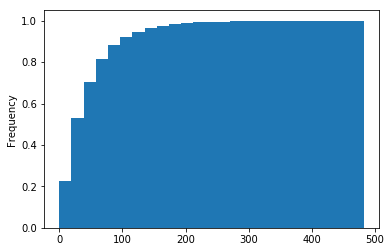

In [25]:
print( 'Mean :', np.mean(review_words) )
review_word_count = pd.Series(review_words)
review_word_count.plot(kind='hist', bins=25, normed=True, cumulative=True)
plt.show()

## Save vectorized text array

In [ ]:
# Save vectorized text into a npy
# https://stackoverflow.com/questions/28439701/how-to-save-and-load-numpy-array-data-properly
filename_out = os.path.join(dir, '02_processed_data','vectorized_reviews.npy')
np.save(filename_out, vectorized_text_array)    # .npy extension is added if not given

# note to load use vectorized_text_array = np.load(filename_out)